# OSPF Service Provider Routing with Netbox and ____

# WIP...

* Not covering notes for all the basics as this is for JNCIP level OSPF, but still some review added in notes
* An C-Style code in the notes is just pseudo-code to get an idea of the structures used -- I find these easier to read than diagrams. These were mostly generated by ChatGPT for me (sometimes with minor modifications).

### Notes
1) General Review
2) LSAs 

### Lab Configurations and Examples
1) Lab Setup with Netbox

---

## 1) General Review

```
# Basic Config
set routing-options router-id 10.1.1.1

set protocols ospf area 0.0.0.0 interface ge-0/0/x.0 interface-type p2p
set protocols ospf area 0.0.0.0 interface ge-0/0/x.0 metric 100 
set protocols ospf area 0.0.0.0 interface lo0.0

# Multiple address configured on an interface and you only want one in OSPF?
# Just use the address instead of the interface name:
set protocols ospf area 0.0.0.0 interface 10.2.2.2

set protocols ospf area 0.0.0.1 interface ge-0/0/y.0
set protocols ospf area 0.0.0.1 nssa

set protocols ospf area 0.0.0.2 interface ge-0/0/y.0
set protocols ospf area 0.0.0.2 stub
```

* DR Election in Juniper:
    * Non-Deterministic; 40 second election period
    * Highest Priority (128 default)
    * Highest Router-ID
    * Just set `interface-type p2p` where possible to avoid where possible

* Router-ID Election
    * Manual   <---Just always do this...make life easy
    * First interface of the router to come online, normally the loopback <--Don't let this happen - assign the router-id manually
        * If first interface to come up, it uses the numerically lowest non 127/8 IP

* Packet Types
    * Hello, DBDs, LSR, LSU, LSA 

```
// All OSPF packets use the same header fields
struct ospf_header {
    uint8_t version;         // OSPF version number
    uint8_t type;            // OSPF packet type (4 for LSU)
    uint16_t packet_length;  // Length of the packet
    uint32_t router_id;      // Router ID
    uint32_t area_id;        // Area ID
    uint16_t checksum;       // Checksum of the entire OSPF packet
    uint16_t autype;         // Authentication type
    uint64_t authentication; // Authentication data (64 bits)
}
```

---

## 2) LSAs

* LSA Overview
    * Max Age limit 3600 seconds
        * Junos refreshes every 3000 seconds by default
        * A single LSU packet can contain multiple LSA packets
    * Other LSA Types
        * Type 6 Group Membership (used in Multicast OSPF)
        * Type 8 External Attributes (Used to tunnel attributes to other protocols)
        * Type 9-11 Opaque LSAs
            * Type 9 used for Graceful Restart 
                * Link-Local scope
            * Type 10 used for MPLS TE
                * Area scope
        * Types 6, 8 and 11 are not supported by Junos
        
#### OSPF LSA Header (Common for all LSAs)
```
struct ospf_lsa_header {
    uint16_t age;                // LSA age
    uint8_t options;             // E-bit (position 7) set in all external LSAs; P-bit (position 5) set in all NSSA External LSAs
    uint8_t type;                // LSA type (1 = Router LSA, 2 = Network LSA, etc.)
    uint32_t lsa_id;             // LSA ID (depends on type)
    uint32_t advertising_router; // Router ID of the advertising router
    uint32_t sequence_number;    // Sequence number for versioning
    uint16_t checksum;           // LSA checksum
    uint16_t length;             // Length of the LSA (including header and body)
}
```

#### LSU
```
struct ospf_lsu {
    struct ospf_header header;  // OSPF common header
    uint32_t num_lsas;          // Number of LSAs in this packet
    uint8_t lsa_data[];         // Variable-length LSAs (Router LSA, Network LSA, etc.)
}
```

### Router LSA (Type 1)

* local-area flood scope
* `show ospf database router extensive`

```
// Router LSA (Type 1)
struct ospf_router_lsa {
    struct ospf_lsa_header header;       // Common LSA header
    uint8_t flags;                       // LSA Flags (B = ABR, E = ASBR, V = Virtual)
    uint8_t flags;                       // Flags (B-bit:P8 (ABR), E-bit:P7 (ASBR), V-bit:P6 (Virtual Link)) 
    uint8_t reserved;                    // Unused, set to 0
    uint16_t link_count;                 // Number of link descriptors
    struct ospf_router_lsa_link links[]; // Variable-length list of links
} 

struct ospf_router_lsa_link {
    uint32_t link_id;     // Link ID (depends on link type)
    uint32_t link_data;   // Link Data (Interface IP, Subnet Mask, etc.)
    uint8_t type;         // Link Type (1 = P2P, 2 = Transit, 3 = Stub, 4 = Virtual)
    uint8_t num_tos;      // Number of TOS entries (deprecated, set to 0)
    uint16_t metric;      // Cost of this link

    // ---------------------------------------------------------------- //
    // Not really sure if these are used any more. I will see in the PCAPs :)
    // ---------------------------------------------------------------- //
    uint8_t num_mt_entries; // Number of MT-ID entries (0 if no MTR)
    struct {
        uint8_t mt_id;          // Multi-Topology ID
        uint16_t mt_metric;     // Metric for this MT-ID
    } mt_entries[];             // Variable-length list of MT-ID entries
    uint32_t additional_data;   // Unused
    // ---------------------------------------------------------------- //
    // ---------------------------------------------------------------- //
    
}


+-------------------------------+--------------------------------+------------------------------+
| Link Type                     | Link ID                        | Link Data                    |
+-------------------------------+--------------------------------+------------------------------+
| Point-to-Point (P2P) (Type 1) | Neighbor’s Router ID           | Local Router’s Interface IP  |
|                               |                                | Address                      |
+-------------------------------+--------------------------------+------------------------------+
| Transit (Type 2)              | Designated Router’s Interface  | Local Router’s Interface IP  |
| (supports M/A Network Links)  | IP Address                     | Address                      |
+-------------------------------+--------------------------------+------------------------------+
| Stub (Type 3)                 | Network Number                 | Subnet Mask                  |
| (Supports P2P, Passive,       |                                |                              |
| and Loopback Interfaces)      |                                |                              |
+-------------------------------+--------------------------------+------------------------------+
| Virtual Link (Type 4)         | Neighbor’s Router ID           | Local Router’s Interface IP  |
|                               |                                | Address                      |
+-------------------------------+--------------------------------+------------------------------+

```

### Nework LSA (Type 2)

* generated by the DR
* local-area flood scope
* LSA ID is the address on the DR interface
* `show ospf database network extensive`

```
// Network LSA (Type 2)
struct ospf_network_lsa {
    struct ospf_lsa_header header; // Common LSA header
    uint32_t network_mask;         // Subnet mask of the network
    uint32_t attached_routers[];   // List of Router IDs connected to this network (variable length)
}
```


### Nework Summary LSA (Type 3)

* area-scope; originated by ABRs
* LSA ID is the destination network
* Adv Router is the IP address of the ABR
* `show ospf database netsummary extensive`

```
// Summary LSA (Type 3) with MT-ID Support
struct ospf_summary_lsa {
    struct ospf_lsa_header header; // Common LSA header
    uint32_t network_mask;         // Subnet mask of the advertised prefix
    uint8_t metric[3];             // 24-bit metric value (cost to reach the network)
    uint8_t options;               // OSPF options (E, MC, NP bits)
    uint8_t num_mt_entries;        // Number of MT-ID entries (0 if MTR is disabled)
    
    // Variable-length Multi-Topology entries
    struct {
        uint8_t mt_id;             // Multi-Topology ID
        uint8_t mt_metric[3];      // 24-bit metric for this topology
    } mt_entries[];                // Flexible array for MT-ID metrics
}
```

### AS Boundary Router Summary LSA (Type 4)
* network mask is always set to 0.0.0.0
* metric is the cost to reach the ASBR
* LSA ID is the ASBR Router ID
* `show ospf database asbrsummary extensive`

```
struct ospf_asbr_summary_lsa {
    struct ospf_lsa_header header; // Common LSA header
    uint32_t network_mask;         // Always 0.0.0.0 for ASBR Summary LSA
    uint8_t metric[3];             // 24-bit metric (cost to reach the ASBR)
    uint8_t options;               // OSPF options (E, MC, NP bits)
    uint8_t num_mt_entries;        // Number of MT-ID entries (0 if no MTR)
    
    // Variable-length Multi-Topology entries
    struct {
        uint8_t mt_id;             // Multi-Topology ID
        uint8_t mt_metric[3];      // 24-bit metric for this topology
    } mt_entries[];                // Flexible array for MT-ID metrics
}
```


### External LSA (Type 5)

* `show ospf database external extensive`
* Domain scope (non-stub areas)
* LSA-ID: external network prefix
* Adv Routers: Router-ID of the ASBR
* E-bit: type-1 or type-2 (0; the default)
    * E-1: cummulative
    * E-2: constant
    * E-1 routes are preferred over E-2 routes 


```
// AS External LSA (Type 5) with MT-ID Support
struct ospf_as_external_lsa {
    struct ospf_lsa_header header; // Common LSA header
    uint32_t network_mask;         // Subnet mask of the advertised prefix
    uint8_t metric[3];             // 24-bit metric (OSPF cost)
    uint8_t flags;                 // E-bit (1 = Type 2 metric, 0 = Type 1 metric)
    uint32_t forwarding_address;   // Next-hop address (if not 0.0.0.0); 0.0.0.0 represents the ASBR itself
    uint32_t external_route_tag;   // Used for policy-based routing
    uint8_t num_mt_entries;        // Number of MT-ID entries (0 if no MTR)
    
    // Variable-length Multi-Topology entries
    struct {
        uint8_t mt_id;             // Multi-Topology ID
        uint8_t mt_metric[3];      // 24-bit metric for this topology
    } mt_entries[];                // Flexible array for MT-ID metrics
}
```

### NSSA LSA (Type 7)

* Generated within a NSSA (or totally NSSA) area and converted to Type 5 by the ABRs
* Uses same format as the Type 5. If the next-hop of the prefix is known internally, that will be used for the forwarding-address field
    * Translated to Type-5 by the ABR with **highest router-ID**
* `show ospf database external extensive`


## OSPF Database Protection
* Protects the LSDB from being overwhelmed...
* **BUT** -- Uwaga! Uwaga! --kills all adjancencies if exceeded!!!
    * set `warning-only` to avoid this
* Useful between PE and CE routers peering via OSPF

```
set protocols ospf database-protection maximum-lsa 1000
set protocols ospf database-protection warning-only
```


## Topology

* Diagrams are WIP
* EVE-NG Lab representing virtual lab. vMXs will be configured with logical-systems -- logical diagram and IP scheme below.
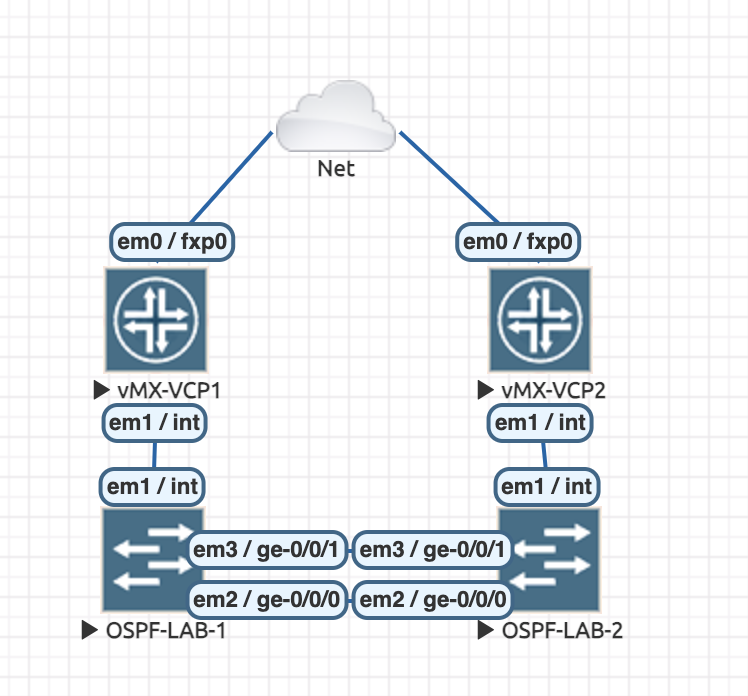

---

* Logical Diagram of logical systems and connection on vMX-OSPF-LAB-1 and vMX-OSPF-LAB-2.
* LS links on vMX-OSPF-LAB-1 will use the IP scheme 10.\<low>.\<high>.\<router_number>/24 for connecting links
    * Example: connection links addressing between LS-10 to LS-5 will be 10.5.10.10 and 10.5.10.5 respectively
* LS links on vMX-OSPF-LAB-2 will use the IP scheme 172.16\<high>\<low>.\<router_number>/24 for connecting links
    * Example: connection links addressing between LS-10 to LS-5 will be 172.16.105.10 and 172.16.105.5 respectively
* TODO: add addressing between the non-logical-systems; label link names; add bridges to connect logical system 5 and 10 to the main vMXs along with associated IP addressing

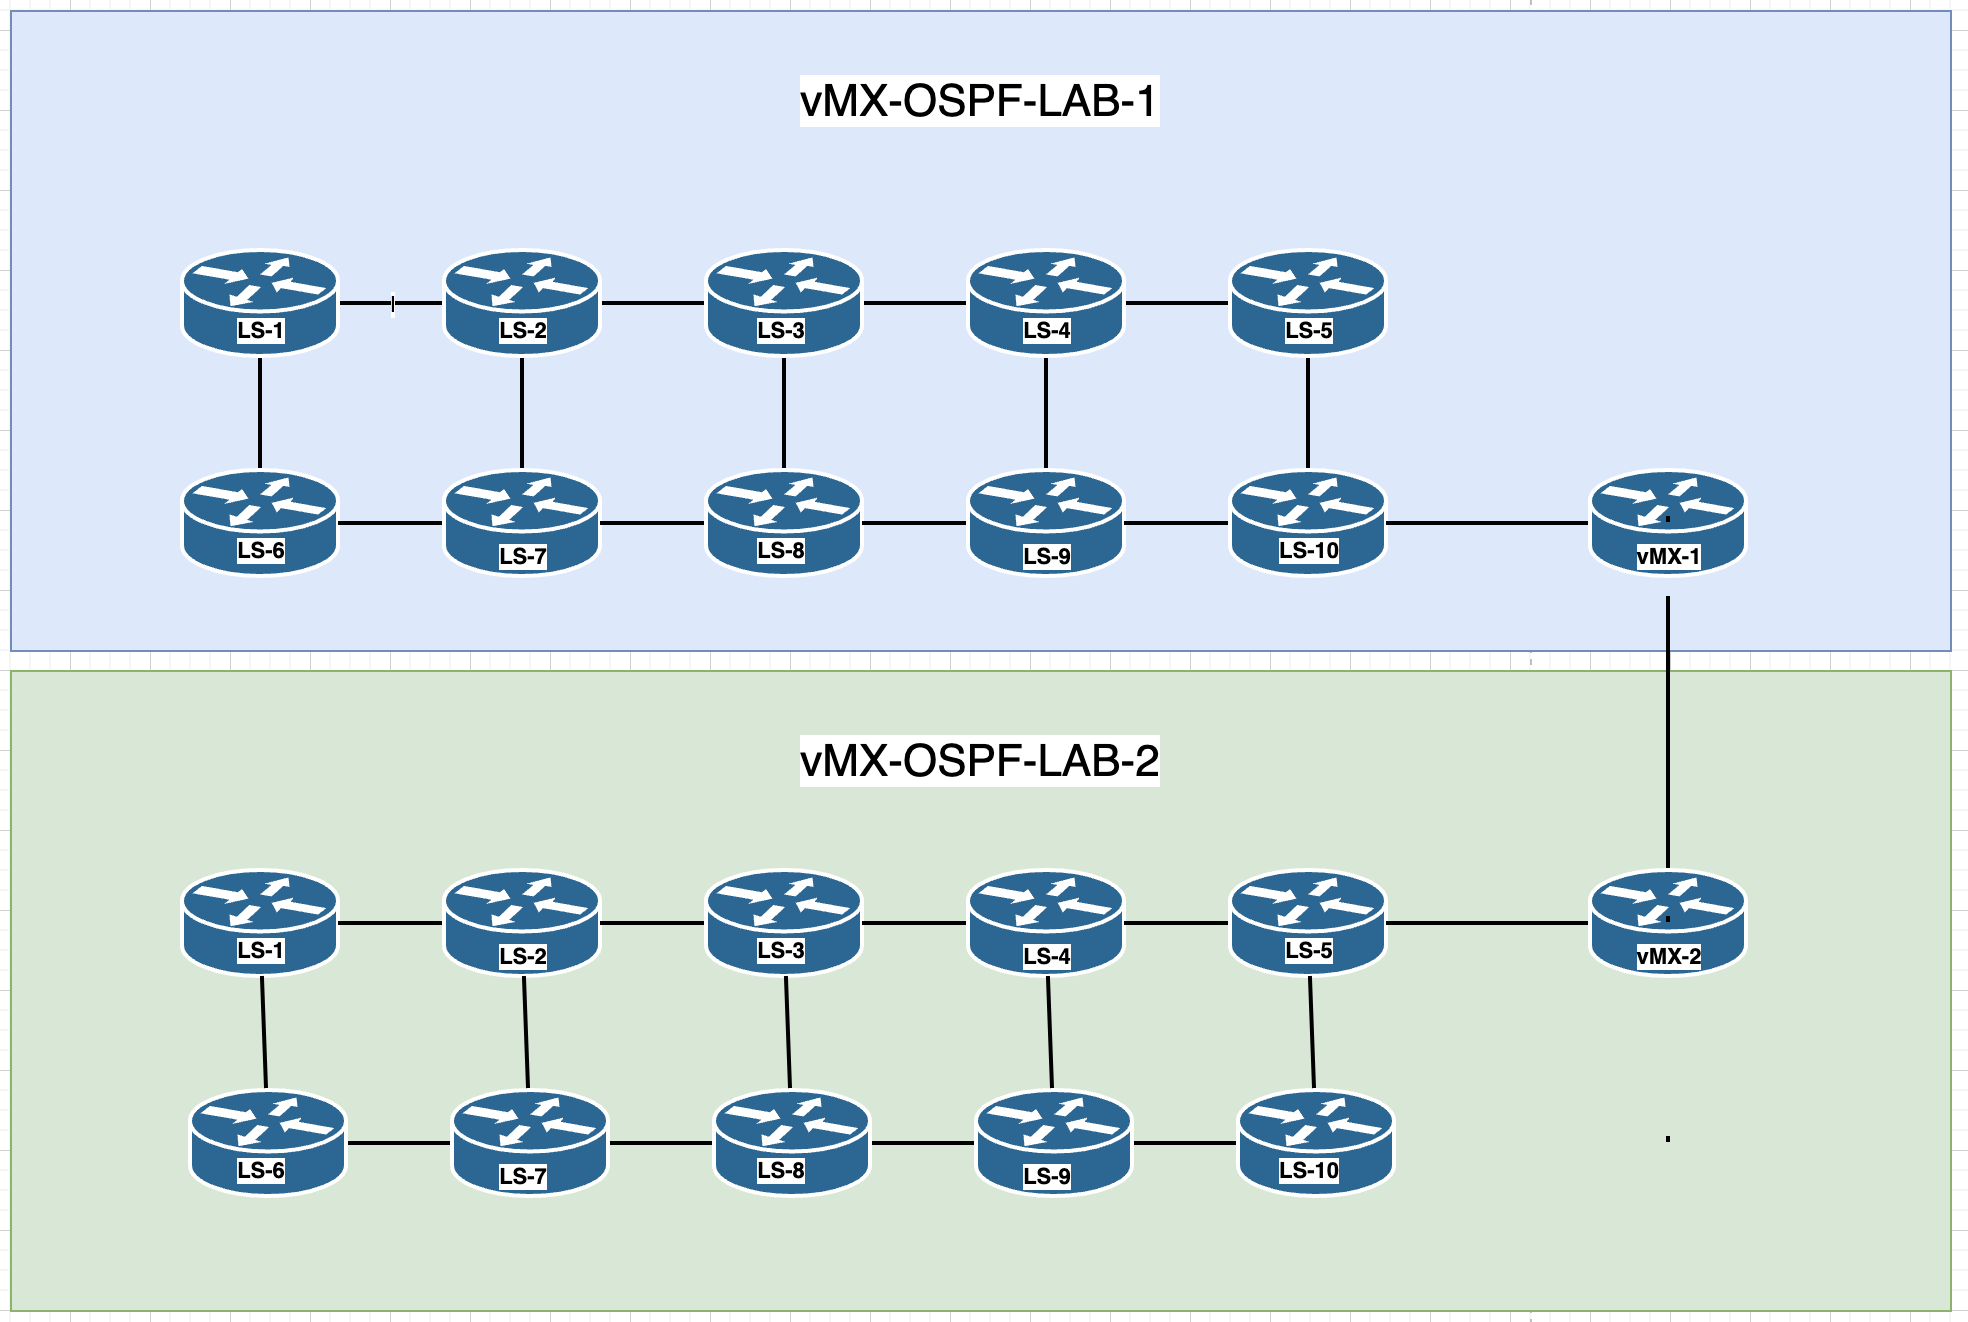

